# FairFace Demographic Inference on FER2013 and RAF-DB

This notebook loads `.npy` images from:
- `data_preprocessed/fer2013_train/`
- `data_preprocessed/rafdb_train/`

Then it uses the FairFace pretrained ResNet-34 model to predict:
- **Gender**
- **Race (7 classes)**
- **Age group**

The output is saved to `inferred_demographics.csv` for later use in EDA and bias mitigation.


In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm


/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load 7-race FairFace model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 18)
checkpoint_path = "/cluster/home/miolate21/FER_biasmitigation1/models/res34_fair_align_multi_7_20190809.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

print("✅ FairFace model loaded on", device)

/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: '/cluster/home/miolate21/FER_biasmitigation1/models/res34_fair_align_multi_7_20190809.pt'

In [9]:
def npy_to_rgb_image(path):
    arr = np.load(path)
    arr = (arr * 255).astype(np.uint8)
    
    if arr.ndim == 3 and arr.shape[-1] == 1:
        arr = arr.squeeze(-1)  # remove grayscale channel
    
    img = Image.fromarray(arr, mode="L").convert("RGB")  # convert to RGB
    return img


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

datasets = {
    "FER2013": "../data_preprocessed/fer2013_train",
    "RAF-DB": "../data_preprocessed/rafdb_train"
}

results = []

race_labels = ["White", "Black", "Latino_Hispanic", "East Asian", "Southeast Asian", "Indian", "Middle Eastern"]
gender_labels = ["Male", "Female"]
age_labels = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"]

for dataset, folder in datasets.items():
    print(f"\n📁 Inference on {dataset}...")
    
    for root, dirs, files in os.walk(folder):
        for fname in tqdm(files):
            if fname.endswith(".npy"):
                path = os.path.join(root, fname)
                img = npy_to_rgb_image(path)
                img_tensor = transform(img).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    output = model(img_tensor).cpu().numpy()[0]
                
                race = race_labels[np.argmax(output[:7])]
                gender = gender_labels[np.argmax(output[7:9])]
                age = age_labels[np.argmax(output[9:18])]
                
                results.append({
                    "image_path": path,
                    "dataset": dataset,
                    "gender": gender,
                    "race": race,
                    "age": age
                })

df = pd.DataFrame(results)
df.to_csv("inferred_demographics.csv", index=False)
print("✅ Done! Saved to inferred_demographics.csv")


📁 Inference on FER2013...


0it [00:00, ?it/s]
100%|██████████| 3995/3995 [00:16<00:00, 244.48it/s]



📁 Inference on RAF-DB...


0it [00:00, ?it/s]
100%|██████████| 1982/1982 [00:08<00:00, 246.92it/s]


✅ Done! Saved to inferred_demographics.csv


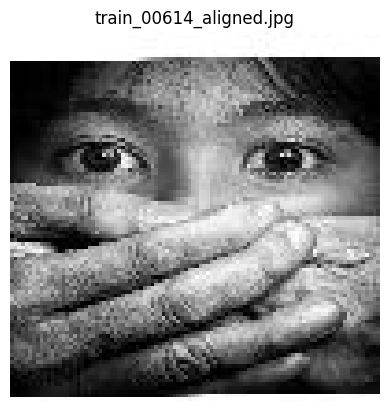

 Prediction for 'train_00614_aligned.jpg':
 Gender: Male
 Race: Southeast Asian
Age Group: 20-29


In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np


base_dir = "/cluster/home/miolate21/FER_biasmitigation1/data/rafdb"

split = "train"
emotion = "fear"
file_name = "train_00614_aligned.jpg"

img_path = os.path.join(base_dir, split, emotion, file_name)

img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title(file_name)
plt.show()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor).cpu().numpy()[0]

race_labels = ["White", "Black", "Latino_Hispanic", "East Asian", "Southeast Asian", "Indian", "Middle Eastern"]
gender_labels = ["Male", "Female"]
age_labels = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"]

race = race_labels[np.argmax(output[:7])]
gender = gender_labels[np.argmax(output[7:9])]
age = age_labels[np.argmax(output[9:18])]

print(f" Prediction for '{file_name}':")
print(f" Gender: {gender}")
print(f" Race: {race}")
print(f"Age Group: {age}")

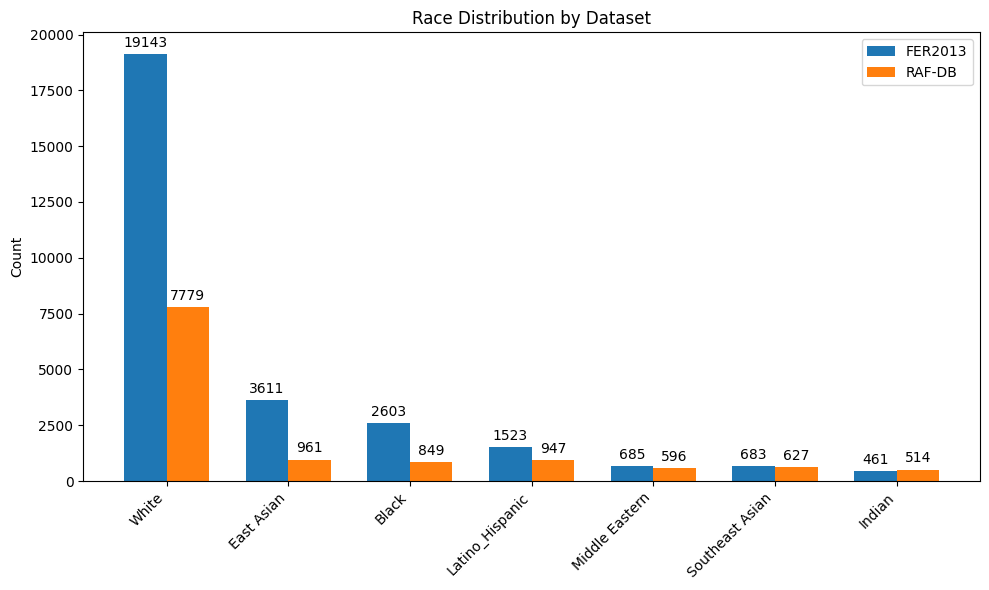

In [16]:
import matplotlib.pyplot as plt
import numpy as np

races = ["White", "East Asian", "Black", "Latino_Hispanic", "Middle Eastern", "Southeast Asian", "Indian"]

counts_fer = [19143, 3611, 2603, 1523, 685, 683, 461]
counts_raf = [7779, 961, 849, 947, 596, 627, 514]

x = np.arange(len(races))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, counts_fer, width, label='FER2013')
rects2 = ax.bar(x + width/2, counts_raf, width, label='RAF-DB')

ax.set_ylabel('Count')
ax.set_title('Race Distribution by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(races, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

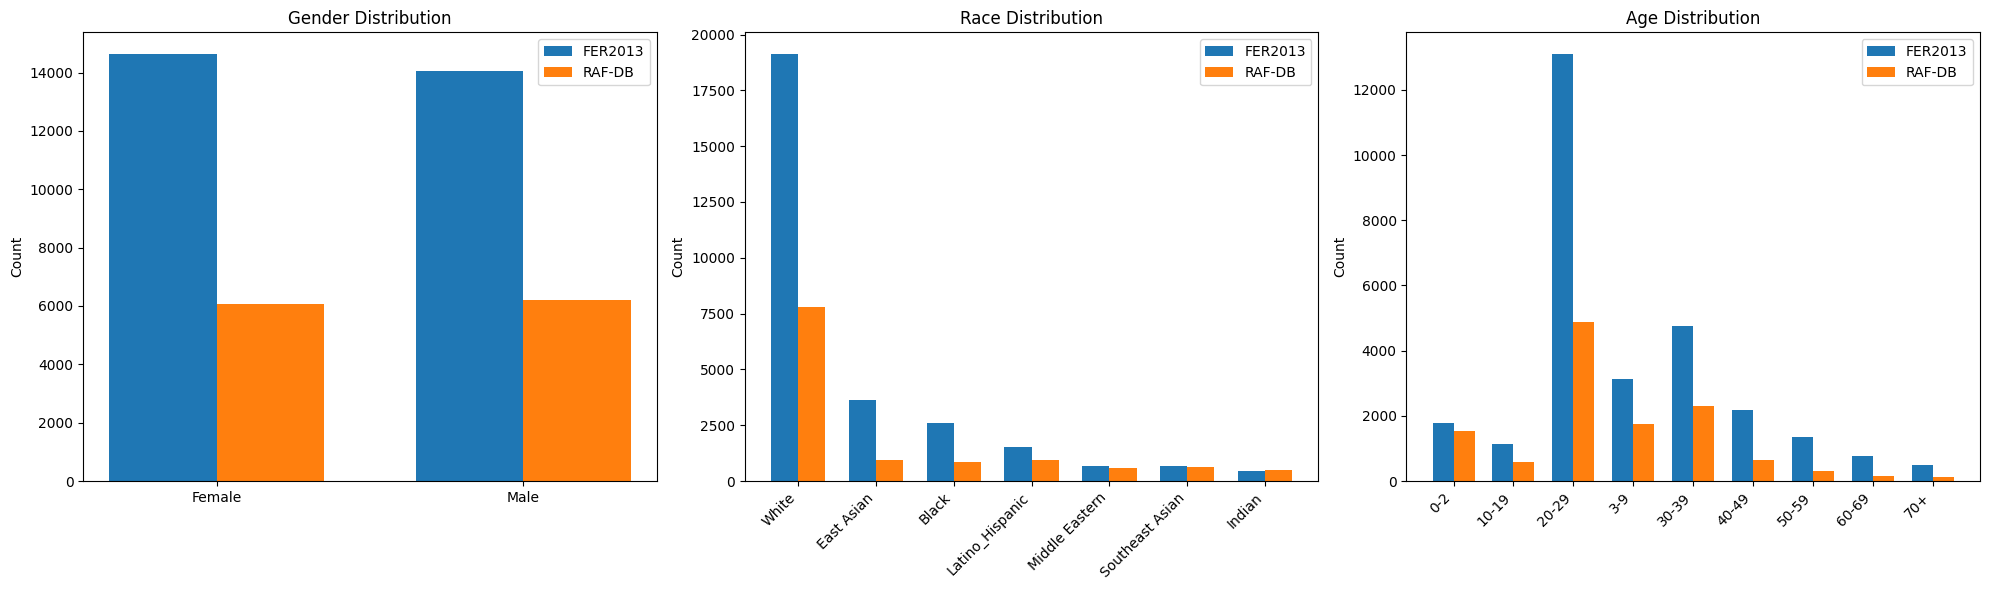

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Data from the analysis
# ---------------------------

# Gender Data
gender_categories = ["Female", "Male"]
gender_fer = [14649, 14060]
gender_raf = [6078, 6195]

# Race Data
race_categories = ["White", "East Asian", "Black", "Latino_Hispanic", "Middle Eastern", "Southeast Asian", "Indian"]
race_fer = [19143, 3611, 2603, 1523, 685, 683, 461]
race_raf = [7779, 961, 849, 947, 596, 627, 514]

# Age Data (using the order in the file)
age_categories = ["0-2", "10-19", "20-29", "3-9", "30-39", "40-49", "50-59", "60-69", "70+"]
age_fer = [1779, 1132, 13108, 3120, 4769, 2187, 1356, 778, 480]
age_raf = [1523, 593, 4880, 1758, 2309, 632, 311, 152, 115]

# ---------------------------
# Plotting the dashboard
# ---------------------------

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
width = 0.35  # Bar width

# 1. Gender Distribution
ax = axes[0]
x = np.arange(len(gender_categories))
rects1 = ax.bar(x - width/2, gender_fer, width, label='FER2013')
rects2 = ax.bar(x + width/2, gender_raf, width, label='RAF-DB')
ax.set_title('Gender Distribution')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(gender_categories)
ax.legend()

# 2. Race Distribution
ax = axes[1]
x = np.arange(len(race_categories))
rects1 = ax.bar(x - width/2, race_fer, width, label='FER2013')
rects2 = ax.bar(x + width/2, race_raf, width, label='RAF-DB')
ax.set_title('Race Distribution')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(race_categories, rotation=45, ha='right')
ax.legend()

# 3. Age Distribution
ax = axes[2]
x = np.arange(len(age_categories))
rects1 = ax.bar(x - width/2, age_fer, width, label='FER2013')
rects2 = ax.bar(x + width/2, age_raf, width, label='RAF-DB')
ax.set_title('Age Distribution')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(age_categories, rotation=45, ha='right')
ax.legend()

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

In [4]:
import os
import pandas as pd

# Load the demographics CSV
df = pd.read_csv('/cluster/home/miolate21/FER_biasmitigation1/results/inferred_demographics.csv')

df['emotion'] = df['image_path'].apply(lambda p: os.path.basename(os.path.dirname(p)))

print(df.head())

df.to_csv('inferred_demographics_with_emotions.csv', index=False)


                                          image_path  dataset gender  \
0  ../data_preprocessed/fer2013_train/neutral/Tra...  FER2013   Male   
1  ../data_preprocessed/fer2013_train/neutral/Tra...  FER2013   Male   
2  ../data_preprocessed/fer2013_train/neutral/Tra...  FER2013   Male   
3  ../data_preprocessed/fer2013_train/neutral/Tra...  FER2013   Male   
4  ../data_preprocessed/fer2013_train/neutral/Tra...  FER2013   Male   

         race    age  emotion  
0       Black  30-39  neutral  
1       Black  40-49  neutral  
2  East Asian  20-29  neutral  
3       White  30-39  neutral  
4       White  10-19  neutral  
